In [45]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [46]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, 'Data')
# print(data_dir)

In [47]:
# read the model info, including the model name, the number of parameters, and the number of MACs
# read the model training info, including the training time, each layer's training time, the epoch time and the epoch energy data
data_model_dir = os.path.join(data_dir, 'model_info')
# read all the model info csv files
model_info_files = os.listdir(data_model_dir)
cifar100_dataset = pd.read_csv(os.path.join(data_model_dir, 'cifar100_datasetinfo.csv'))
fashionmnist_modelinfo = pd.read_csv(os.path.join(data_model_dir, 'fashionmnist_datasetinfo.csv'))

In [48]:
print(cifar100_dataset.head(),'\n',
      '*'*50, '\n',
      fashionmnist_modelinfo.head())

      Model          MACs   Parameters  TotalEnergyPerEpoch  \
0   Alexnet  7.123900e+08   57040000.0              2985.59   
1     VGG11  7.640000e+09  129180000.0             23860.35   
2     VGG16  1.552000e+10  134670000.0             46992.02   
3  ResNet18  1.830000e+09   11230000.0              9525.80   
4  ResNet34  3.680000e+09   21340000.0             15869.56   

   AverageEnergyPerSec  TotalTime  AverageTimeperEpoch  Total Time to Device  \
0               135.45     431.56                21.58                100.94   
1               294.21    1618.57                80.93                114.94   
2               340.52    2749.50               137.48                115.99   
3               210.37     897.24                44.86                114.59   
4               255.15    1234.98                61.75                120.02   

   Average Time to Device  Total Forward Time  Average Forward Time  \
0                    5.05               36.81                  1.84  

In [49]:
# seperate the vgg model data with others
vgg_data_f = fashionmnist_modelinfo[fashionmnist_modelinfo['Model'].str.contains('VGG')]
vgg_data_c = cifar100_dataset[cifar100_dataset['Model'].str.contains('VGG')]

# remove the vgg model data from the original data
model_data_f = fashionmnist_modelinfo[~fashionmnist_modelinfo['Model'].str.contains('VGG')]
model_data_c = cifar100_dataset[~cifar100_dataset['Model'].str.contains('VGG')]

In [50]:
vgg_data_f

,Model,MACs,Parameters,TotalEnergyPerEpoch,AverageEnergyPerSec,TotalTime,AverageTimeperEpoch,Total Time to Device,Average Time to Device,Total Forward Time,Average Forward Time,Total Backward Time,Average Backward Time,Total Test Time,Average Test Time
1,VGG11,7.580000e+09,128810000.0,27264.35,324.59,1667.45,83.37,47.60,2.38,477.64,23.88,939.96,47.0,110.53,5.53
2,VGG16,1.546000e+10,134300000.0,54043.96,360.06,2987.17,149.36,47.13,2.36,890.96,44.55,1778.02,88.9,179.09,8.95


In [51]:
# find out the MACs of each model
macs_train_f = model_data_f['MACs'].values.reshape(-1, 1)
macs_test_f = vgg_data_f['MACs'].values.reshape(-1, 1)
macs_train_c = model_data_c['MACs'].values.reshape(-1, 1)
macs_test_c = vgg_data_c['MACs'].values.reshape(-1, 1)
# find out the energy of each model
energy_train_f = model_data_f['TotalEnergyPerEpoch'].values.reshape(-1, 1)
energy_test_f = vgg_data_f['TotalEnergyPerEpoch'].values.reshape(-1, 1)
energy_train_c = model_data_c['TotalEnergyPerEpoch'].values.reshape(-1, 1)
energy_test_c = vgg_data_c['TotalEnergyPerEpoch'].values.reshape(-1, 1)

# print(macs_train_f,'\n','*'*50,'\n',macs_test_f)
# print('*'*50)
# print(energy_train_f, '\n','*'*50,'\n', energy_test_f)

In [52]:
model_onlymacs_f = LinearRegression()
model_onlymacs_f.fit(macs_train_f, energy_train_f)
vgg_pred_f = model_onlymacs_f.predict(macs_test_f)
r2_f = model_onlymacs_f.score(macs_test_f, energy_test_f)

print(f'The predict values are: {vgg_pred_f}')
print('*'*50)
print(f'The actual values are: {energy_test_f}')
print('*'*50)
print(f'The R2 score is: {r2_f}')

The predict values are: [[35781.38018037]
 [70130.52487955]]
**************************************************
The actual values are: [[27264.35]
 [54043.96]]
**************************************************
The R2 score is: 0.07601332421020324


In [53]:
model_onlymacs_c = LinearRegression()
model_onlymacs_c.fit(macs_train_c, energy_train_c)
vgg_pred_c = model_onlymacs_c.predict(macs_test_c)
r2_c = model_onlymacs_c.score(macs_test_c, energy_test_c)

print(f'The predict values are: {vgg_pred_c}')
print('*'*50)
print(f'The actual values are: {energy_test_c}')
print('*'*50)
print(f'The R2 score is: {r2_c}')

The predict values are: [[31089.19721814]
 [60123.33267323]]
**************************************************
The actual values are: [[23860.35]
 [46992.02]]
**************************************************
The R2 score is: 0.1601627486935504


In [80]:
def PlotMACs_vs_Energy(df, macs_test, energy_pred, energy_test, model_name):
    # first plot the MACs vs Energy of the training data, and then plot the MACs vs Energy of the test data and the predicted data in the same plot
    # set the prediction data as green, the test data as red, and the training data as blue
    # the predicted data is the linear regression model's prediction, and use the dot to represent the data
    extended_x_min = min(df['MACs'].min(), macs_test.min()) * 0.8  # slightly more than minimum
    extended_x_max = max(df['MACs'].max(), macs_test.max()) * 1.2  # slightly more than maximum

    # Generate extended x values
    extended_x = np.linspace(extended_x_min, extended_x_max, 100)  # generate 100 points for a smooth line
    plt.figure(figsize=(10, 6))
    plt.scatter(df['MACs'], df['TotalEnergyPerEpoch'], color='blue', label='Training Data')
    plt.scatter(macs_test, energy_test, color='red', label='Test Data')
    plt.scatter(macs_test, energy_pred, color='green', label='Predicted Data')
    # plot the predict line, with the model coefficient and intercept, plot it as green and extend the line
    model_coef = model_name.coef_
    model_intercept = model_name.intercept_
    extended_y = model_coef * extended_x + model_intercept
    plt.plot(extended_x, extended_y.reshape(-1,1), color='green', label='Regression Line')
    plt.xlabel('MACs')
    plt.ylabel('Energy')
    plt.legend()
    plt.show()
    

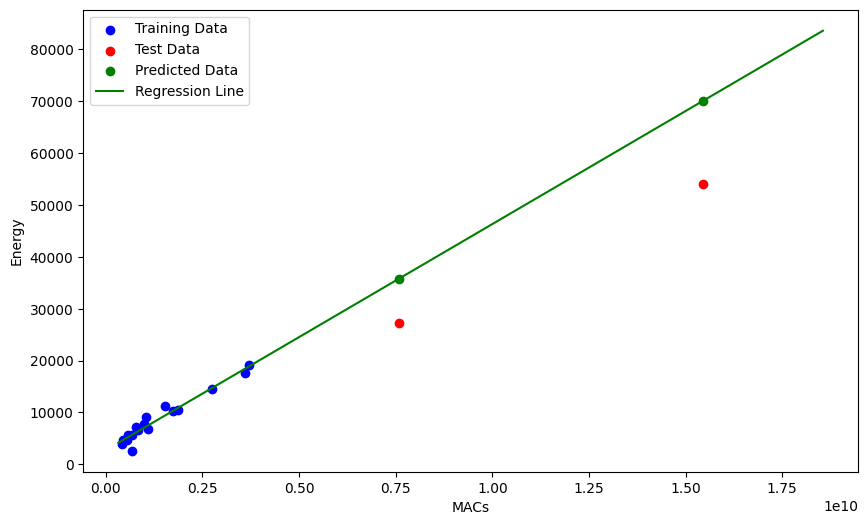

In [81]:
PlotMACs_vs_Energy(model_data_f, macs_test_f, vgg_pred_f, energy_test_f, model_onlymacs_f)

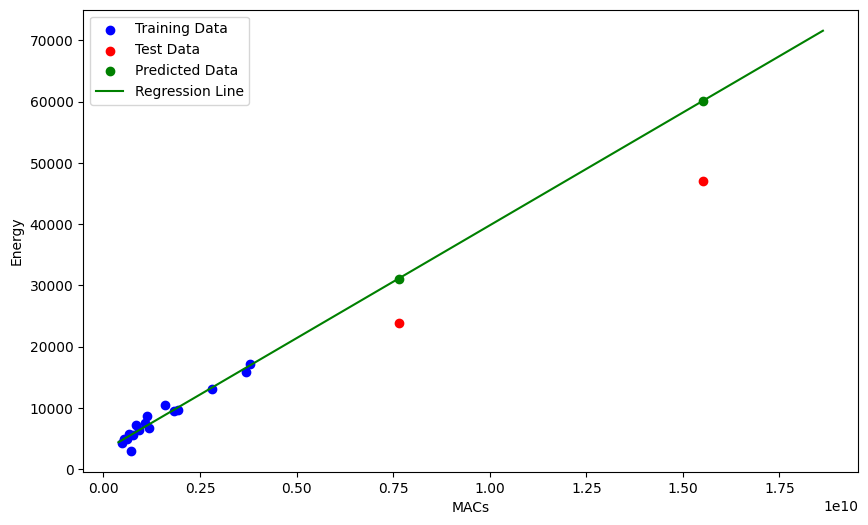

In [82]:
PlotMACs_vs_Energy(model_data_c, 
                    macs_test_c, 
                     vgg_pred_c, 
                  energy_test_c,
                  model_onlymacs_c)

### create a new ml model with more input dimension  
the train value include vgg11, let the test value is vgg16 only

In [56]:
# seperate the vgg model data with others
testdata_only16_f = fashionmnist_modelinfo[fashionmnist_modelinfo['Model'].str.contains('VGG16')]
testdata_only16_c = cifar100_dataset[cifar100_dataset['Model'].str.contains('VGG16')]

# remove the vgg model data from the original data
modeldata_only16_f = fashionmnist_modelinfo[~fashionmnist_modelinfo['Model'].str.contains('VGG16')]
modeldata_only16_c = cifar100_dataset[~cifar100_dataset['Model'].str.contains('VGG16')]

In [57]:
# find out the MACs of each model
mac_train_only16_f = modeldata_only16_f['MACs'].values.reshape(-1, 1)
mac_test_only16_f = testdata_only16_f['MACs'].values.reshape(-1, 1)
mac_train_only16_c = modeldata_only16_c['MACs'].values.reshape(-1, 1)
mac_test_only16_c = testdata_only16_c['MACs'].values.reshape(-1, 1)
# find out the energy of each model
energy_train_only16_f = modeldata_only16_f['TotalEnergyPerEpoch'].values.reshape(-1, 1)
energy_test_only16_f = testdata_only16_f['TotalEnergyPerEpoch'].values.reshape(-1, 1)
energy_train_only16_c = modeldata_only16_c['TotalEnergyPerEpoch'].values.reshape(-1, 1)
energy_test_only16_c = testdata_only16_c['TotalEnergyPerEpoch'].values.reshape(-1, 1)


In [58]:
# print(mac_train_only16_f, '\n', '*'*50, '\n', mac_test_only16_f)

In [61]:
model_macwithvgg11_f = LinearRegression()
model_macwithvgg11_f.fit(mac_train_only16_f, energy_train_only16_f)
only16_pred_f = model_macwithvgg11_f.predict(mac_test_only16_f)
# r2_only16_f = model_macwithvgg11_f.score(mac_test_only16_f, energy_test_only16_f)

print(f'The predict values are: {only16_pred_f}')
print('*'*50)
print(f'The actual values are: {energy_test_only16_f}')
print('*'*50)
# print(f'The R2 score is: {r2_only16_f}')

The predict values are: [[56978.67573486]]
**************************************************
The actual values are: [[54043.96]]
**************************************************
The R2 score is: nan


/Users/dtjgp/miniconda3/envs/new/lib/python3.11/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [65]:
# show the coefficient and the intercept of the model
print(f'The coefficient is: {model_macwithvgg11_f.coef_}')
print(f'The intercept is: {model_macwithvgg11_f.intercept_}')

The coefficient is: [[3.43665355e-06]]
The intercept is: [3848.01180073]


In [62]:
model_macwithvgg11_c = LinearRegression()
model_macwithvgg11_c.fit(mac_train_only16_c, energy_train_only16_c)
only16_pred_c = model_macwithvgg11_c.predict(mac_test_only16_c)
# r2_only16_f = model_macwithvgg11_f.score(mac_test_only16_f, energy_test_only16_f)

print(f'The predict values are: {only16_pred_c}')
print('*'*50)
print(f'The actual values are: {energy_test_only16_c}')
print('*'*50)
# print(f'The R2 score is: {r2_only16_f}')

The predict values are: [[48973.72273756]]
**************************************************
The actual values are: [[46992.02]]
**************************************************


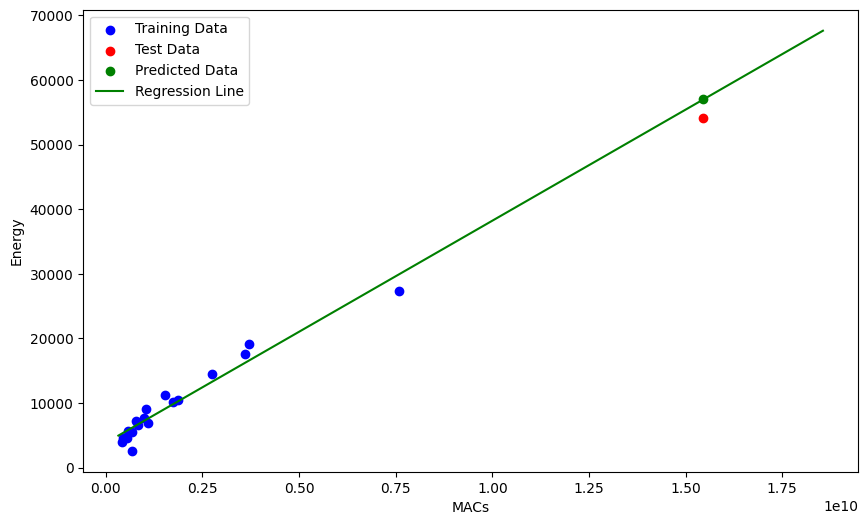

In [83]:
PlotMACs_vs_Energy(modeldata_only16_f, 
                    mac_test_only16_f, 
                        only16_pred_f, 
                 energy_test_only16_f,
                 model_macwithvgg11_f)

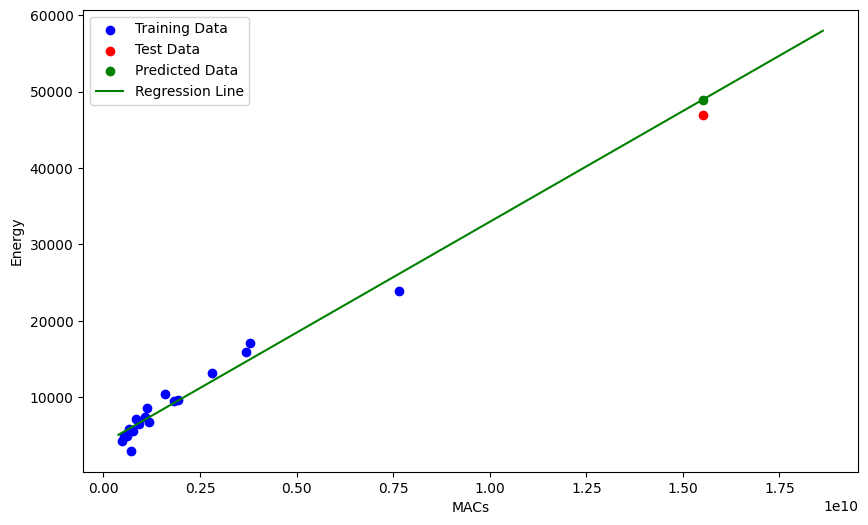

In [84]:
PlotMACs_vs_Energy(modeldata_only16_c, 
                    mac_test_only16_c, 
                        only16_pred_c, 
                 energy_test_only16_c,
                 model_macwithvgg11_c)